In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import librosa.display
import pywt
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_csv('normalized_records.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3960,3961,3962,3963,3964,3965,3966,3967,3968,3969,3970,3971,3972,3973,3974,3975,3976,3977,3978,3979,3980,3981,3982,3983,3984,3985,3986,3987,3988,3989,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,-0.015699,-0.018623,-0.021721,-0.024923,-0.027847,-0.029204,-0.029657,-0.029831,-0.029622,-0.029274,-0.029030,-0.028891,-0.028787,-0.028648,-0.028543,-0.028439,-0.028265,-0.028160,-0.028056,-0.027917,-0.027673,-0.027220,-0.026698,-0.025967,-0.024853,-0.024088,-0.023740,-0.023496,-0.023322,-0.023113,-0.022939,-0.022800,-0.022626,-0.022452,-0.022278,-0.022103,-0.021964,-0.021825,-0.021651,-0.021442,...,-0.003446,-0.004038,-0.004386,-0.004630,-0.004734,-0.004630,-0.004456,-0.004142,-0.003620,-0.003376,-0.003272,-0.003202,-0.003168,-0.003098,-0.003063,-0.003028,-0.002959,-0.002924,-0.002889,-0.002854,-0.002785,-0.002750,-0.002680,-0.002611,-0.002506,-0.002228,-0.001949,-0.001740,-0.001601,-0.001497,-0.001392,-0.001323,-0.001253,-0.001183,-0.001044,-0.000835,-0.000557,-0.000278,-0.000070,0.000070
1,0.007494,0.009030,0.010845,0.012753,0.014243,0.015220,0.015779,0.016104,0.016384,0.016616,0.016849,0.017175,0.017501,0.017734,0.017966,0.018152,0.018292,0.018339,0.018292,0.018059,0.017687,0.017315,0.016756,0.015872,0.015080,0.014475,0.014056,0.013638,0.013079,0.012521,0.012148,0.011822,0.011497,0.011217,0.010985,0.010845,0.010705,0.010612,0.010473,0.010379,...,-0.003630,-0.003863,-0.004003,-0.004096,-0.004189,-0.004236,-0.004329,-0.004375,-0.004422,-0.004468,-0.004561,-0.004608,-0.004701,-0.004794,-0.004887,-0.005027,-0.005260,-0.005632,-0.006563,-0.007680,-0.008471,-0.009030,-0.008937,-0.007168,-0.003677,0.001815,0.009588,0.019037,0.029090,0.037934,0.042309,0.042309,0.037934,0.029137,0.019502,0.011543,0.006004,0.002700,0.000605,-0.002048
2,-0.003283,-0.003568,-0.003853,-0.004139,-0.004852,-0.005851,-0.006993,-0.008135,-0.008991,-0.009419,-0.009562,-0.009419,-0.009277,-0.009134,-0.008848,-0.008563,-0.008278,-0.007992,-0.007707,-0.007421,-0.007421,-0.008135,-0.009277,-0.010276,-0.010704,-0.011132,-0.011703,-0.012131,-0.012559,-0.012845,-0.013273,-0.013558,-0.013844,-0.014129,-0.014414,-0.014557,-0.014557,-0.014414,-0.014272,-0.014272,...,0.000285,0.000000,0.000000,-0.000428,-0.001142,-0.001142,-0.000285,0.000000,0.000285,0.000571,0.000856,0.000999,0.000999,0.000999,0.000999,0.000999,0.000856,0.000714,0.000714,0.000571,0.000571,0.000428,0.000428,0.000428,0.000428,0.000571,0.000714,0.000714,0.000856,0.000999,0.000999,0.001142,0.001142,0.001142,0.001142,0.000999,0.000856,0.000714,0.000428,0.000285
3,-0.018883,-0.023060,-0.026987,-0.031165,-0.033671,-0.034925,-0.035593,-0.036094,-0.036428,-0.036679,-0.036763,-0.036763,-0.036679,-0.036512,-0.036178,-0.035676,-0.035175,-0.034590,-0.034256,-0.033922,-0.033671,-0.033337,-0.033003,-0.032669,-0.032251,-0.031917,-0.031582,-0.031248,-0.030998,-0.030747,-0.030580,-0.030413,-0.030246,-0.030079,-0.029828,-0.029661,-0.029243,-0.028575,-0.028073,-0.027823,...,-0.000418,0.000000,0.000251,0.000501,0.000752,0.001003,0.001253,0.001504,0.001838,0.002172,0.002423,0.002674,0.002924,0.003259,0.003509,0.003843,0.004178,0.004512,0.004930,0.005347,0.005849,0.006350,0.006684,0.007018,0.007353,0.007687,0.008104,0.008522,0.008940,0.009358,0.009776,0.010277,0.010862,0.011530,0.012115,0.012700,0.013285,0.013870,0.014454,0.015206
4,-0.007691,-0.009663,-0.011701,-0.013147,-0.014133,-0.014593,-0.014331,-0.013739,-0.013147,-0.012556,-0.011964,-0.011241,-0.010123,-0.008546,-0.007757,-0.007428,-0.007100,-0.006837,-0.006442,-0.006113,-0.005719,-0.005193,-0.004602,-0.003747,-0.002827,-0.001972,-0.000460,0.001512,0.002958,0.003878,0.004667,0.005325,0.006311,0.008151,0.009860,0.010912,0.011767,0.012556,0.013739,0.015711,...,0.004141,0.003615,0.002958,0.002038,0.000394,-0.001380,-0.003155,-0.004996,-0.006771,-0.009137,-0.012030,-0.013607,-0.014396,-0.014988,-0.015579,-0.016303,-0.017026,-0.017815,-0.018538,-0.019458,-0.

In [ ]:
labels = pd.read_csv('labels.csv', header = None)

In [ ]:
spect = []
for i in range(0, 20):
    stft  = librosa.core.spectrum.stft(np.array(df.iloc[i]))
    out = 2 * np.abs(stft) / np.sum(300)
    spect.append(out)



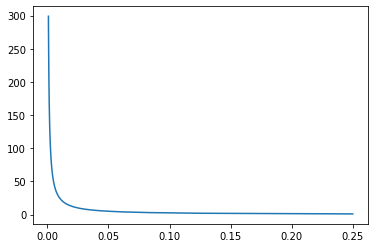

In [ ]:

scale = np.arange(1,300)
coef, freq = pywt.cwt(spect[1], scale, wavelet='mexh')

plt.plot(freq, scale)
plt.show()

In [ ]:
from skimage.transform import resize

def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = X.shape[2] 
    
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals), dtype = 'float32')
    
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        for signal in range(n_signals):
            serie = X[sample, :, signal]
            # continuous wavelet transform 
            coeffs, freqs = pywt.cwt(serie, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode = 'constant')
            X_cwt[sample,:,:,signal] = rescale_coeffs
            
    return X_cwt

# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size
n_scales = 64
X_train_cwt = create_cwt_images(np.array(spect), n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")

0
shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (20, 64, 64, 8)


In [ ]:
X_train_cwt[0].shape

(64, 64, 8)

In [ ]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
#import keras (high level API) wiht tensorflow as backend
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

def build_cnn_model(activation, input_shape):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D()) 
    model.add(Flatten())
    
    # 3 Full connected layer
    model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(54, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(3, activation = 'softmax')) # 6 classes
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
    
    # define callbacks
    callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)]
    
    # fit the model
    history = model.fit(x=X_train,
                        y=y_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))
    
    return model, history

TensorFlow version: 2.7.0


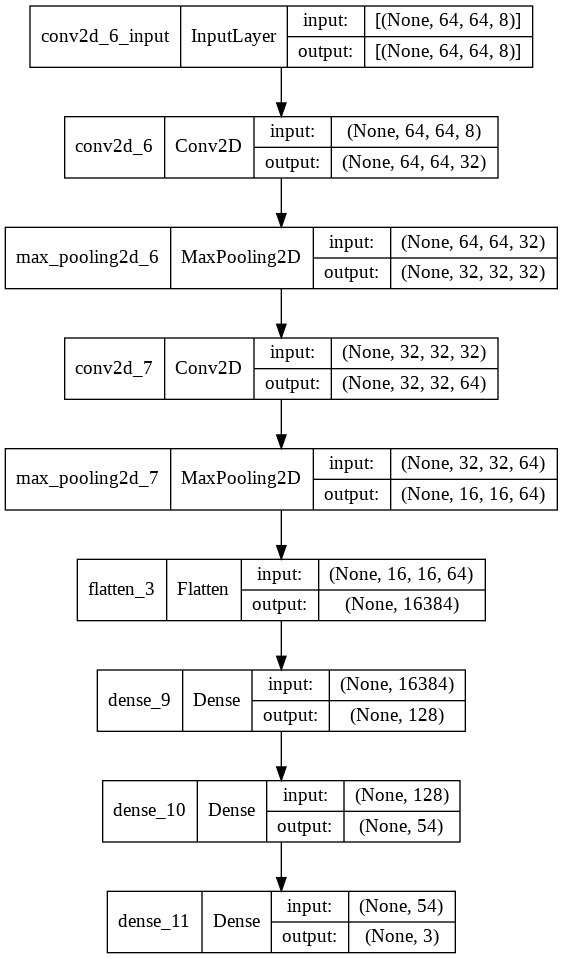

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
labels = [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 2, 0]

In [ ]:
# shape of the input images
input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)

labels = np.array(labels)

X_test_cwt = X_train_cwt[16:]
y_test = labels[16:]

# train cnn model
model, history = compile_and_fit_model(cnn_model, X_train_cwt, labels, X_test_cwt, y_test, 368, 75)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 64, 64, 32)        2336      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 16384)             0         
                                                                 
 dense_33 (Dense)            (None, 128)             

In [ ]:
history=model.history.history
print(history)

test_loss, test_acc = model.evaluate(X_test_cwt,  y_test, verbose=2)
print(test_loss)
print(test_acc)

{'loss': [1.100915551185608, 1.086183786392212, 1.0505958795547485, 0.9861922264099121, 0.9135522842407227, 0.9004895091056824, 0.9428342580795288, 0.9202983975410461, 0.8883800506591797, 0.8819301724433899, 0.8917512893676758, 0.8991273641586304, 0.8979722857475281, 0.8901503682136536, 0.880082905292511, 0.8732937574386597, 0.873924732208252, 0.8763446807861328, 0.8728063702583313, 0.8655190467834473, 0.8610442280769348, 0.8599724769592285, 0.8574539422988892, 0.851757824420929, 0.8453909754753113, 0.8413785696029663, 0.8368908762931824, 0.8293052911758423, 0.8212045431137085, 0.8140664100646973, 0.8060966730117798, 0.7962436676025391, 0.786279559135437, 0.7762497663497925, 0.7644845247268677, 0.7530728578567505, 0.7430356740951538, 0.7290222644805908, 0.7179859280586243, 0.7051843404769897, 0.692467212677002, 0.6790202856063843, 0.6653002500534058, 0.6516801118850708, 0.6333796977996826, 0.6203345656394958, 0.6069685220718384, 0.5926840901374817, 0.570803701877594, 0.5602351427078247

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


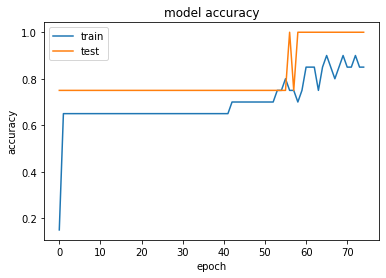

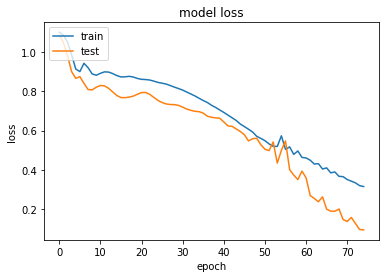

In [ ]:
# list all data in history
print(history.keys())

# summarize history for accuracy
plt.plot(history['sparse_categorical_accuracy'])
plt.plot(history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
